# Compute embeddings from race ranking data

Here's the next step! The algorithm finds hidden factors (called embeddings) that summarize a racer's and a race's profile. Inspired from this [Kaggle notebook](https://www.kaggle.com/code/sborms/collaborative-filtering-deep-dive).

A script version of part of this notebook is in `scripts/train.py`.

In [1]:
print(f"\33[1m\33[33mLet's go\33[0m!")

Let's go!


## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastai.collab import *
from fastai.tabular.all import *
from torch import nn

## Functions

In [3]:
def normalize_results_by_race(df, how):
    if how == "0-1":
        return df.rank(axis=1, pct=True, ascending=False, na_option="keep")  # 1.0 means first, 0.0 means last in race
    if how == "1-20":
        return df.clip(upper=20)  # logic is inversed here: higher values indicates lower performance
    if how == "bins":
        return df.apply(lambda x: pd.cut(x,
                                         bins=[1, 3, 5, 10, 20, 200],  # podium, top-5, top-10, top-20, not in contention
                                         labels=[5, 4, 3, 2, 1],  # from best to worse race result, NaN is not participated/finished
                                         include_lowest=True
                                        )
                       )

def get_year_weight(year, decay=0.25):
    """Give more weight to current and more recent years."""  # bias seems to be impacted by how long riders are active
    return np.exp(-decay * (CURR_YEAR - year))  # if decay factor is set higher, earlier years receive less weight

def get_race_class_weight(race_class):
    """Give more weight to most important races."""
    return {"UWT": 2, "Pro": 1.5, "1": 0.75, "2": 0.5}[race_class]

def get_stage_weight(stage: bool):
    """Give less weight to stages from a multi-stage race."""
    return 0.8 if stage is True else 1

def get_gc_weight(gc: bool):
    """Give more weight to general classification outcomes."""
    return 1.25 if gc is True else 1

def extract_factors(learn, dim):
    return learn.model.u_weight.weight if dim == "rider" else learn.model.i_weight.weight if dim == "stage" else None

def extract_bias(learn, dim):
    return learn.model.u_bias.weight.squeeze() if dim == "rider" else learn.model.i_bias.weight.squeeze() if dim == "stage" else None

def extract_most_similar_elements(learn, dim="rider", element="VAN AERT Wout", n=20):
    assert dim in ["rider", "stage"], "Dimension should be 'rider' or 'stage'."
    factors = extract_factors(learn, dim)
    idx = learn.dls.classes[dim].o2i[element]
    sim = nn.CosineSimilarity(dim=1)(factors, factors[idx][None])
    # pd.Series(sim.detach()).sort_values(ascending=False).reset_index(drop=True).plot()  # twisted S-shape
    idx_topn = sim.argsort(descending=True)[1:(n+1)]
    return learn.dls.classes[dim][idx_topn]

def plot_pca(df, learn, dim, n_plot=50):
    g = df.groupby(dim)["result"].count()
    top_dim = g.sort_values(ascending=False).index.values[:]  # takes riders with most races, or races with most participants
    top_idxs = tensor([learn.dls.classes[dim].o2i[m] for m in top_dim])

    factors = extract_factors(learn, dim)
    w = factors[top_idxs].cpu().detach()

    pca = w.pca(3)
    fac0, fac1, fac2 = pca.t()
    idxs = list(range(n_plot))
    X, Y = fac0[idxs], fac2[idxs]

    plt.figure(figsize=(7, 7))
    plt.scatter(X, Y)
    for i, x, y in zip(top_dim[idxs], X, Y):
        plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=9)
    plt.show()

## Config

In [4]:
CURR_YEAR = 2023
BS = 64  # batch size
NORMALIZE_HOW = "bins"  # "0-1", "1-20", "bins"
MIN_N_PARTICIPATIONS = 20  # a rider is considered only if they did at least this amount of race participations
N_FACTORS = 10  # number of hidden factors
Y_RANGE = (0, 5.25 * 2)  # (0, 1) or (1, 20.5) or (0, 5.25), multiply by max. of race class weighting

## Compute embeddings

In [5]:
df_results = pd.read_csv("../data/matrix_race_results.csv",
                         index_col=[0, 1, 2],
                         dtype={"year": str, "stage_slug": str, "class": str})

In [6]:
df_results = df_results[df_results.columns[df_results.count(axis=0) >= MIN_N_PARTICIPATIONS]]

In [7]:
df_results.filter(regex="VAN AERT Wout").dropna().head()

VAN AERT Wout
year stage_slug                        class               
2022 omloop-het-nieuwsblad/2022/result 1.UWT            1.0
     paris-nice/2022/gc                2.UWT           32.0
     paris-nice/2022/stage-1/result    2.UWT            3.0
     paris-nice/2022/stage-2/result    2.UWT            2.0
     paris-nice/2022/stage-3/result    2.UWT            3.0

In [8]:
df_results = normalize_results_by_race(df_results, how=NORMALIZE_HOW)
df_results = df_results.astype(float)

In [9]:
df_results.filter(regex="VAN AERT Wout").dropna().head()

VAN AERT Wout
year stage_slug                        class               
2022 omloop-het-nieuwsblad/2022/result 1.UWT            5.0
     paris-nice/2022/gc                2.UWT            1.0
     paris-nice/2022/stage-1/result    2.UWT            5.0
     paris-nice/2022/stage-2/result    2.UWT            5.0
     paris-nice/2022/stage-3/result    2.UWT            5.0

In [10]:
df_reweight = df_results.index.to_frame().reset_index(drop=True)

In [11]:
df_reweight["w_year"] = df_reweight["year"].astype(int).apply(get_year_weight)
df_reweight["w_class"] = df_reweight["class"].str.partition(".")[2].apply(get_race_class_weight)
df_reweight["w_stage"] = df_reweight["stage_slug"].str.contains("/stage-").apply(get_stage_weight)
df_reweight["w_gc"] = ((df_reweight["class"].str.contains("2")) & (df_reweight["stage_slug"].str.endswith("/"))).apply(get_gc_weight)
df_reweight["w"] = df_reweight["w_year"] * df_reweight["w_class"] * df_reweight["w_stage"] * df_reweight["w_gc"]
df_reweight.set_index(["year", "stage_slug", "class"], inplace=True)

In [12]:
print(sorted(np.round(df_reweight["w"].unique(), 2)))

[0.31, 0.39, 0.4, 0.47, 0.5, 0.58, 0.6, 0.75, 0.93, 1.17, 1.2, 1.25, 1.5, 1.56, 1.6, 2.0]


In [13]:
# scale race results by weights
df_results.loc[:, :] = df_results.to_numpy() * df_reweight[["w"]].to_numpy()

In [14]:
df_results.filter(regex="VAN AERT Wout").dropna().sample(5)

VAN AERT Wout
year stage_slug                          class               
2023 paris-roubaix/2023/result           1.UWT      10.000000
2022 tour-de-france/2022/stage-14/result 2.UWT       1.246081
     milano-sanremo/2022/result          1.UWT       4.672805
     paris-nice/2022/gc                  2.UWT       1.557602
2023 tour-de-suisse/2023/stage-1/result  2.UWT       8.000000

In [15]:
df = pd.melt(df_results.reset_index(drop=False).drop(columns=["year", "class"]), id_vars="stage_slug")
df.rename(columns={"stage_slug": "stage", "variable": "rider", "value": "result"}, inplace=True)
df = df[["rider", "stage", "result"]]  # rider = user, stage (race) = item, result = rating

In [16]:
df_ = df.dropna()
df_.rider.nunique(), df_.stage.nunique()

(1996, 1385)

In [17]:
dls = CollabDataLoaders.from_df(df_, bs=BS)
dls.show_batch()

c:\Users\saborms\Desktop\GITHUB\cyclingsimilarity.com\.venv\lib\site-packages\fastai\data\transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
c:\Users\saborms\Desktop\GITHUB\cyclingsimilarity.com\.venv\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):
c:\Users\saborms\Desktop\GITHUB\cyclingsimilarity.com\.venv\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


,rider,stage,result
0,SELIG Rüdiger,oxyclean-classic-brugge-de-panne/2022/result,1.557602
1,MØRKØV Michael,tour-of-denmark/2023/gc,1.500000
2,HIVERT Jonathan,tour-du-finistere/2022/result,1.168201
3,KIRSCH Alex,tour-de-france/2022/stage-3/result,1.246081
4,HUYS Laurens,giro-d-italia/2023/stage-18/result,1.600000
5,PLAMONDON Robin,gp-de-la-ville-de-lillers/2022/result,0.389400
6,WOLFENBUTTEL Nils,midden-brabant-poort-omloop/2022/result,0.389400
7,LIPOWITZ Florian,giro-della-regione-friuli-venezia-giulia/2022/stage-1/result,0.934561
8,BARTHE Cyril,arctic-race-of-norway/2023/gc,1.500000
9,BAYER Tobias,vuelta-a-espana/2023/stage-12/result,1.600000


In [18]:
learn = collab_learner(dls, n_factors=N_FACTORS, y_range=Y_RANGE)

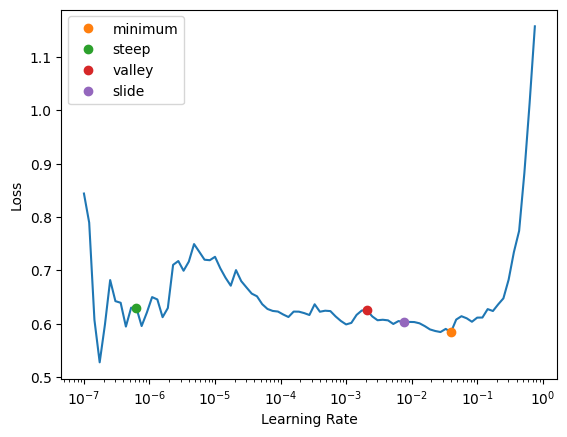

In [36]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [38]:
learn.fit_one_cycle(5, lrs.valley, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.652559,0.637365,00:24


In [21]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(1997, 10)
  (i_weight): Embedding(1386, 10)
  (u_bias): Embedding(1997, 1)
  (i_bias): Embedding(1386, 1)
)

In [22]:
learn.export("../data/learner.pkl")

## Interpretation

### Bias

In [23]:
rider_bias = extract_bias(learn, "rider")
[dls.classes["rider"][i] for i in rider_bias.argsort(descending=True)[:10]]  # "best"/most consistent riders across all seasons

['POGAČAR Tadej',
 'PEDERSEN Mads',
 'EVENEPOEL Remco',
 'VAN AERT Wout',
 'VINGEGAARD Jonas',
 'KOOIJ Olav',
 '#na#',
 'YATES Simon',
 'ROGLIČ Primož',
 'DE LIE Arnaud']

In [24]:
race_bias = extract_bias(learn, "stage")
[dls.classes["stage"][i] for i in race_bias.argsort(descending=True)[:10]]

['vuelta-a-burgos/2023/stage-2/result',
 'paris-nice/2023/stage-3/result',
 'uae-tour/2023/stage-2/result',
 '#na#',
 'tour-of-qinghai-lake/2022/stage-2/result',
 'vuelta-a-espana/2023/stage-1/result',
 'tour-of-qinghai-lake/2022/stage-6/result',
 'bretagne-classic/2023/result',
 'e3-harelbeke/2023/result',
 'tour-de-romandie/2023/gc']

### PCA

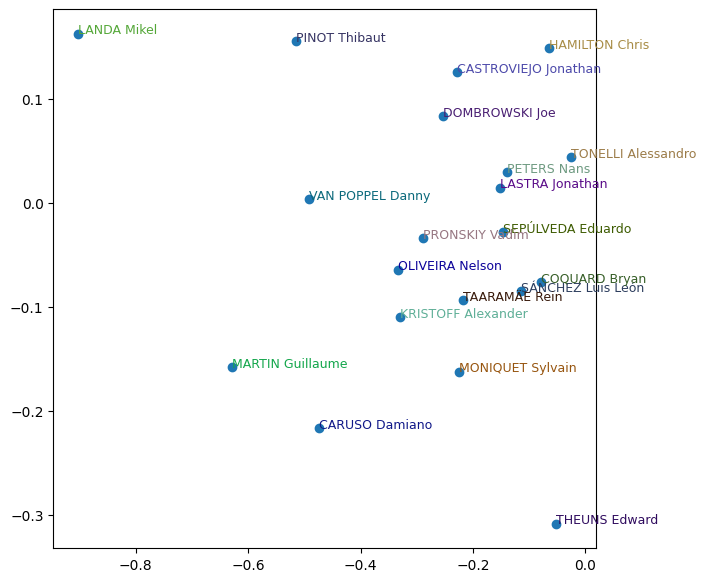

In [25]:
plot_pca(df, learn, "rider", n_plot=20)

In [26]:
# plot_pca(df, learn, "stage", n_plot=10)

### Similarity

In [27]:
spotcheck_riders = ["VAN AERT Wout", "VAN DER POEL Mathieu", "VAN AVERMAET Greg", "ALAPHILIPPE Julian", "POGAČAR Tadej", "EVENEPOEL Remco", "MAS Enric"]
for r in spotcheck_riders:
    print(r.ljust(20), "|", extract_most_similar_elements(learn, "rider", r, 7))

VAN AERT Wout        | ['PEDERSEN Mads', 'GIRMAY Biniam', 'ASGREEN Kasper', 'TRENTIN Matteo', 'STRONG Corbin', 'KANTER Max', 'PHILIPSEN Jasper']
VAN DER POEL Mathieu | ['KÜNG Stefan', 'POWLESS Neilson', 'MOHORIČ Matej', 'VAN GILS Maxim', 'ARENSMAN Thymen', 'GRÉGOIRE Romain', 'CARAPAZ Richard']
VAN AVERMAET Greg    | ['HESSMANN Michel', 'CATALDO Dario', 'MEYER Cameron', 'VAN MELSEN Kévin', 'SERRY Pieter', 'CHEREL Mikaël', 'PLANCKAERT Edward']
ALAPHILIPPE Julian   | ['BRENNER Marco', 'COMBAUD Romain', 'BOASSON HAGEN Edvald', 'COSNEFROY Benoît', 'BETTIOL Alberto', 'BEWLEY Sam', 'TEUNISSEN Mike']
POGAČAR Tadej        | ['EVENEPOEL Remco', 'AYUSO Juan', 'ROGLIČ Primož', 'VLASOV Aleksandr', 'VINGEGAARD Jonas', 'ALMEIDA João', 'YATES Adam']
EVENEPOEL Remco      | ['ROGLIČ Primož', 'VLASOV Aleksandr', 'AYUSO Juan', 'ALMEIDA João', 'YATES Adam', 'VINGEGAARD Jonas', 'BILBAO Pello']
MAS Enric            | ['LÓPEZ Miguel Ángel', 'BILBAO Pello', 'UIJTDEBROEKS Cian', 'BARDET Romain', 'KUSS Sepp', 'J

In [30]:
spotcheck_stages = ["paris-roubaix/2022/result", "dauphine/2022/stage-6/result", "liege-bastogne-liege/2022/result"]
for r in spotcheck_stages:
    print(r, "\n", extract_most_similar_elements(learn, "stage", r, 10), "\n", sep="")

paris-roubaix/2022/result
['tour-of-oman/2023/stage-2/result', 'tour-de-luxembourg/2022/gc', 'tour-of-norway/2023/stage-2/result', 'tour-of-oman/2023/stage-4/result', 'e3-harelbeke/2023/result', 'gran-camino/2023/stage-2/result', 'circuit-franco-belge/2022/result', 'vuelta-ciclista-a-la-provincia-de-san-juan/2023/stage-4/result', 'strade-bianche/2023/result', 'tour-of-denmark/2022/gc']

dauphine/2022/stage-6/result
['volta-ao-algarve/2023/stage-1/result', 'eschborn-frankfurt/2022/result', 'tour-down-under/2023/stage-1/result', 'volta-ao-algarve/2022/stage-3/result', 'giro-d-italia/2023/stage-10/result', 'clasica-de-almeria/2023/result', 'tour-of-belgium/2023/stage-5/result', 'tour-of-oman/2022/stage-1/result', 'clasica-de-almeria/2022/result', 'tour-of-denmark/2022/stage-1/result']

liege-bastogne-liege/2022/result
['trofeo-andratx-mirador-d-es-colomer/2023/result', 'deutschland-tour/2023/stage-3/result', 'dwars-door-vlaanderen/2023/result', 'gent-wevelgem/2023/result', 'tour-of-britai